# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

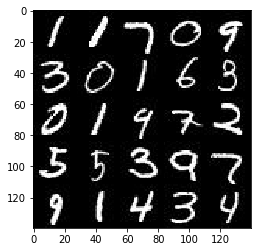

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

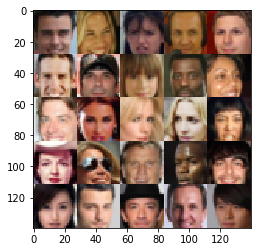

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, shape=())

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        relu2 = tf.maximum(alpha * x2, x2)
        bn2 = tf.layers.batch_normalization(relu2, training=True)
        # 7x7x128
        
        x3 = tf.layers.conv2d(bn2, 256, 5, strides=2, padding='same')
        relu3 = tf.maximum(alpha * x3, x3)
        bn3 = tf.layers.batch_normalization(relu3, training=True)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(bn3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse=False
    alpha=0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
        
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    alpha=0.2
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    inputs_real, inputs_z, Learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    print_every=10
    show_every=100
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z, inputs_real: batch_images})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6707... Generator Loss: 1.1484
Epoch 1/2... Discriminator Loss: 0.5013... Generator Loss: 3.6806
Epoch 1/2... Discriminator Loss: 0.7462... Generator Loss: 3.3793
Epoch 1/2... Discriminator Loss: 2.1669... Generator Loss: 0.2603
Epoch 1/2... Discriminator Loss: 0.7328... Generator Loss: 1.5555
Epoch 1/2... Discriminator Loss: 0.6825... Generator Loss: 1.2893
Epoch 1/2... Discriminator Loss: 0.4693... Generator Loss: 1.8322
Epoch 1/2... Discriminator Loss: 1.4228... Generator Loss: 4.9248
Epoch 1/2... Discriminator Loss: 0.4759... Generator Loss: 2.3571
Epoch 1/2... Discriminator Loss: 0.3542... Generator Loss: 2.0626


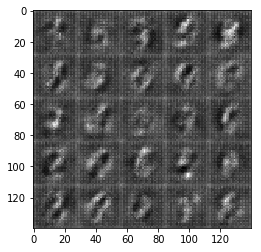

Epoch 1/2... Discriminator Loss: 0.4295... Generator Loss: 1.3931
Epoch 1/2... Discriminator Loss: 0.2659... Generator Loss: 2.0752
Epoch 1/2... Discriminator Loss: 0.2558... Generator Loss: 2.5095
Epoch 1/2... Discriminator Loss: 0.1890... Generator Loss: 2.7882
Epoch 1/2... Discriminator Loss: 0.1300... Generator Loss: 3.5179
Epoch 1/2... Discriminator Loss: 0.1620... Generator Loss: 2.3067
Epoch 1/2... Discriminator Loss: 6.9487... Generator Loss: 13.6276
Epoch 1/2... Discriminator Loss: 0.6764... Generator Loss: 4.4985
Epoch 1/2... Discriminator Loss: 0.2442... Generator Loss: 2.0502
Epoch 1/2... Discriminator Loss: 0.1568... Generator Loss: 2.5907


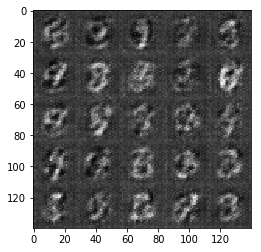

Epoch 1/2... Discriminator Loss: 2.7843... Generator Loss: 7.9307
Epoch 1/2... Discriminator Loss: 0.3120... Generator Loss: 2.2614
Epoch 1/2... Discriminator Loss: 0.2775... Generator Loss: 3.9230
Epoch 1/2... Discriminator Loss: 0.2216... Generator Loss: 2.7911
Epoch 1/2... Discriminator Loss: 0.1927... Generator Loss: 2.1742
Epoch 1/2... Discriminator Loss: 0.1316... Generator Loss: 2.7263
Epoch 1/2... Discriminator Loss: 0.7231... Generator Loss: 0.8211
Epoch 1/2... Discriminator Loss: 0.2047... Generator Loss: 2.8489
Epoch 1/2... Discriminator Loss: 0.1644... Generator Loss: 2.6544
Epoch 1/2... Discriminator Loss: 0.1402... Generator Loss: 2.7681


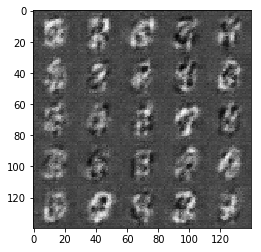

Epoch 1/2... Discriminator Loss: 0.0969... Generator Loss: 3.3910
Epoch 1/2... Discriminator Loss: 0.1192... Generator Loss: 3.9831
Epoch 1/2... Discriminator Loss: 0.1427... Generator Loss: 3.1212
Epoch 1/2... Discriminator Loss: 0.0791... Generator Loss: 3.8159
Epoch 1/2... Discriminator Loss: 0.0988... Generator Loss: 3.0531
Epoch 1/2... Discriminator Loss: 0.1361... Generator Loss: 2.8931
Epoch 1/2... Discriminator Loss: 0.1435... Generator Loss: 2.5346
Epoch 1/2... Discriminator Loss: 0.0860... Generator Loss: 3.3302
Epoch 1/2... Discriminator Loss: 0.1526... Generator Loss: 4.1635
Epoch 1/2... Discriminator Loss: 0.0729... Generator Loss: 4.3771


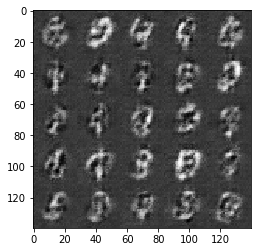

Epoch 1/2... Discriminator Loss: 0.0841... Generator Loss: 3.2199
Epoch 1/2... Discriminator Loss: 2.7346... Generator Loss: 8.4403
Epoch 1/2... Discriminator Loss: 0.3126... Generator Loss: 2.1341
Epoch 1/2... Discriminator Loss: 0.2167... Generator Loss: 2.6733
Epoch 1/2... Discriminator Loss: 0.1882... Generator Loss: 2.5891
Epoch 1/2... Discriminator Loss: 0.2070... Generator Loss: 2.3755
Epoch 2/2... Discriminator Loss: 0.1838... Generator Loss: 2.4696
Epoch 2/2... Discriminator Loss: 0.1588... Generator Loss: 2.7032
Epoch 2/2... Discriminator Loss: 0.1308... Generator Loss: 3.0580
Epoch 2/2... Discriminator Loss: 0.1470... Generator Loss: 2.6827


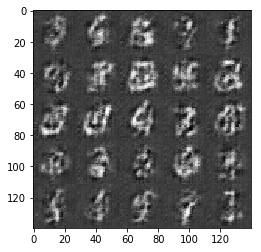

Epoch 2/2... Discriminator Loss: 0.1134... Generator Loss: 3.1219
Epoch 2/2... Discriminator Loss: 0.1077... Generator Loss: 3.1692
Epoch 2/2... Discriminator Loss: 0.0921... Generator Loss: 3.1189
Epoch 2/2... Discriminator Loss: 0.1336... Generator Loss: 2.5877
Epoch 2/2... Discriminator Loss: 0.0815... Generator Loss: 3.1708
Epoch 2/2... Discriminator Loss: 0.1099... Generator Loss: 2.9737
Epoch 2/2... Discriminator Loss: 0.0964... Generator Loss: 3.1180
Epoch 2/2... Discriminator Loss: 0.0873... Generator Loss: 3.0279
Epoch 2/2... Discriminator Loss: 0.0658... Generator Loss: 3.4542
Epoch 2/2... Discriminator Loss: 0.0807... Generator Loss: 3.3115


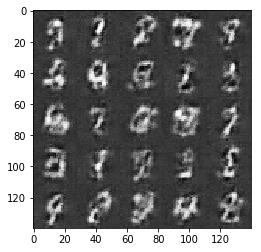

Epoch 2/2... Discriminator Loss: 0.0916... Generator Loss: 3.6566
Epoch 2/2... Discriminator Loss: 0.0836... Generator Loss: 3.2603
Epoch 2/2... Discriminator Loss: 0.0764... Generator Loss: 3.3231
Epoch 2/2... Discriminator Loss: 0.0875... Generator Loss: 3.0038
Epoch 2/2... Discriminator Loss: 0.0958... Generator Loss: 2.8794
Epoch 2/2... Discriminator Loss: 0.0929... Generator Loss: 2.9770
Epoch 2/2... Discriminator Loss: 0.0712... Generator Loss: 3.9005
Epoch 2/2... Discriminator Loss: 13.2022... Generator Loss: 17.4221
Epoch 2/2... Discriminator Loss: 0.2513... Generator Loss: 2.5294
Epoch 2/2... Discriminator Loss: 0.1750... Generator Loss: 2.7970


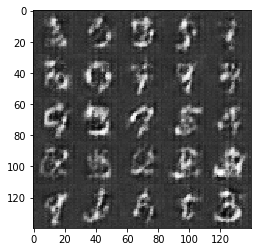

Epoch 2/2... Discriminator Loss: 0.1449... Generator Loss: 2.7128
Epoch 2/2... Discriminator Loss: 0.1293... Generator Loss: 2.8063
Epoch 2/2... Discriminator Loss: 0.1076... Generator Loss: 3.1284
Epoch 2/2... Discriminator Loss: 0.1763... Generator Loss: 2.2401
Epoch 2/2... Discriminator Loss: 0.1616... Generator Loss: 2.4366
Epoch 2/2... Discriminator Loss: 0.0924... Generator Loss: 3.0479
Epoch 2/2... Discriminator Loss: 0.0729... Generator Loss: 3.4091
Epoch 2/2... Discriminator Loss: 0.0793... Generator Loss: 3.1077
Epoch 2/2... Discriminator Loss: 0.1629... Generator Loss: 2.2359
Epoch 2/2... Discriminator Loss: 0.0632... Generator Loss: 3.5603


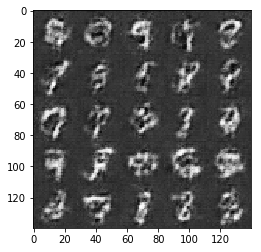

Epoch 2/2... Discriminator Loss: 0.0728... Generator Loss: 3.3076
Epoch 2/2... Discriminator Loss: 0.0700... Generator Loss: 3.2460
Epoch 2/2... Discriminator Loss: 0.0674... Generator Loss: 3.3688
Epoch 2/2... Discriminator Loss: 0.0517... Generator Loss: 3.7116
Epoch 2/2... Discriminator Loss: 0.0638... Generator Loss: 3.6142
Epoch 2/2... Discriminator Loss: 0.0615... Generator Loss: 3.3700
Epoch 2/2... Discriminator Loss: 0.0567... Generator Loss: 3.6291
Epoch 2/2... Discriminator Loss: 0.0648... Generator Loss: 3.4087
Epoch 2/2... Discriminator Loss: 0.0478... Generator Loss: 3.9407
Epoch 2/2... Discriminator Loss: 0.0569... Generator Loss: 3.4586


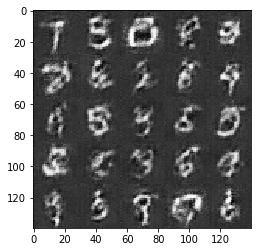

Epoch 2/2... Discriminator Loss: 0.0548... Generator Loss: 3.4669
Epoch 2/2... Discriminator Loss: 0.0724... Generator Loss: 3.2106
Epoch 2/2... Discriminator Loss: 0.0451... Generator Loss: 3.8080


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.0218... Generator Loss: 16.0492
Epoch 1/1... Discriminator Loss: 0.0318... Generator Loss: 11.4345
Epoch 1/1... Discriminator Loss: 0.6253... Generator Loss: 3.6815
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 1.0258
Epoch 1/1... Discriminator Loss: 0.5809... Generator Loss: 2.5111
Epoch 1/1... Discriminator Loss: 0.5708... Generator Loss: 1.6573
Epoch 1/1... Discriminator Loss: 0.9998... Generator Loss: 0.9776
Epoch 1/1... Discriminator Loss: 0.1663... Generator Loss: 2.6896
Epoch 1/1... Discriminator Loss: 0.3278... Generator Loss: 1.8061
Epoch 1/1... Discriminator Loss: 0.2595... Generator Loss: 2.3469


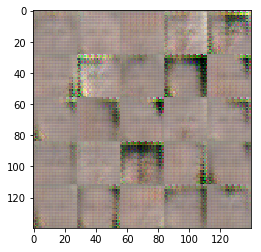

Epoch 1/1... Discriminator Loss: 0.0538... Generator Loss: 4.6001
Epoch 1/1... Discriminator Loss: 0.0558... Generator Loss: 4.2340
Epoch 1/1... Discriminator Loss: 0.2360... Generator Loss: 2.7697
Epoch 1/1... Discriminator Loss: 1.6450... Generator Loss: 0.6298
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 0.9430
Epoch 1/1... Discriminator Loss: 0.9721... Generator Loss: 0.9044
Epoch 1/1... Discriminator Loss: 1.0711... Generator Loss: 0.8324
Epoch 1/1... Discriminator Loss: 1.9330... Generator Loss: 0.3607
Epoch 1/1... Discriminator Loss: 0.5999... Generator Loss: 2.6877
Epoch 1/1... Discriminator Loss: 3.1012... Generator Loss: 2.3033


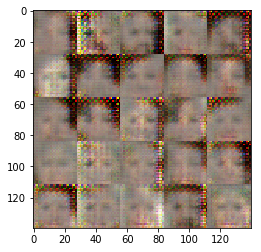

Epoch 1/1... Discriminator Loss: 0.2122... Generator Loss: 2.7831
Epoch 1/1... Discriminator Loss: 0.1476... Generator Loss: 3.1979
Epoch 1/1... Discriminator Loss: 4.6252... Generator Loss: 0.0925
Epoch 1/1... Discriminator Loss: 0.5747... Generator Loss: 1.5454
Epoch 1/1... Discriminator Loss: 0.3818... Generator Loss: 2.1566
Epoch 1/1... Discriminator Loss: 1.7649... Generator Loss: 2.8329
Epoch 1/1... Discriminator Loss: 1.7067... Generator Loss: 1.2175
Epoch 1/1... Discriminator Loss: 1.7281... Generator Loss: 1.0676
Epoch 1/1... Discriminator Loss: 1.2480... Generator Loss: 1.5649
Epoch 1/1... Discriminator Loss: 1.5508... Generator Loss: 2.0438


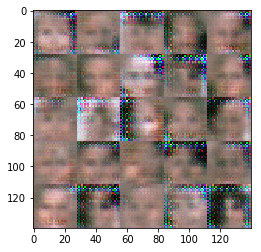

Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 1.4655
Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 1.6345
Epoch 1/1... Discriminator Loss: 1.5879... Generator Loss: 0.8934
Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 0.9155
Epoch 1/1... Discriminator Loss: 1.5414... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.6856... Generator Loss: 0.8451
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 0.8216
Epoch 1/1... Discriminator Loss: 1.5662... Generator Loss: 1.0296
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 1.1907
Epoch 1/1... Discriminator Loss: 0.3496... Generator Loss: 2.0932


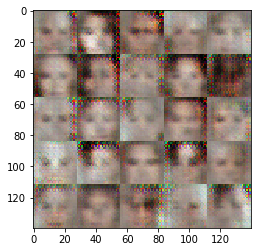

Epoch 1/1... Discriminator Loss: 0.2574... Generator Loss: 3.0965
Epoch 1/1... Discriminator Loss: 0.5586... Generator Loss: 1.5321
Epoch 1/1... Discriminator Loss: 1.9350... Generator Loss: 0.4416
Epoch 1/1... Discriminator Loss: 0.0475... Generator Loss: 4.1233
Epoch 1/1... Discriminator Loss: 1.5147... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.5785... Generator Loss: 0.6212
Epoch 1/1... Discriminator Loss: 1.5836... Generator Loss: 1.9776
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 1.6181
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.4354
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 2.7589


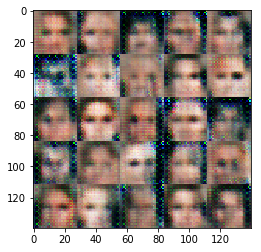

Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 0.5086
Epoch 1/1... Discriminator Loss: 0.7147... Generator Loss: 2.4425
Epoch 1/1... Discriminator Loss: 1.2380... Generator Loss: 1.2354
Epoch 1/1... Discriminator Loss: 0.6577... Generator Loss: 1.2249
Epoch 1/1... Discriminator Loss: 0.1946... Generator Loss: 2.7942
Epoch 1/1... Discriminator Loss: 1.9070... Generator Loss: 1.5291
Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 1.0823
Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 1.3861
Epoch 1/1... Discriminator Loss: 1.6879... Generator Loss: 0.3987
Epoch 1/1... Discriminator Loss: 1.1017... Generator Loss: 1.0005


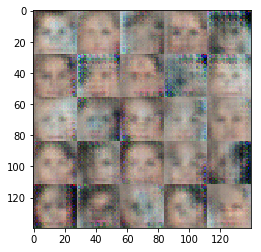

Epoch 1/1... Discriminator Loss: 1.5305... Generator Loss: 1.2030
Epoch 1/1... Discriminator Loss: 0.9463... Generator Loss: 2.8748
Epoch 1/1... Discriminator Loss: 1.4464... Generator Loss: 1.6291
Epoch 1/1... Discriminator Loss: 1.5313... Generator Loss: 0.6318
Epoch 1/1... Discriminator Loss: 1.5093... Generator Loss: 1.1773
Epoch 1/1... Discriminator Loss: 1.5194... Generator Loss: 0.4501
Epoch 1/1... Discriminator Loss: 1.5857... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 0.9823... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.6040... Generator Loss: 1.5507
Epoch 1/1... Discriminator Loss: 1.2969... Generator Loss: 0.8462


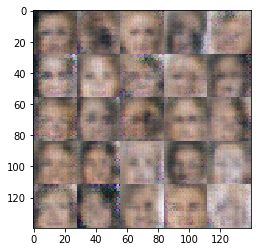

Epoch 1/1... Discriminator Loss: 0.6551... Generator Loss: 0.9813
Epoch 1/1... Discriminator Loss: 0.3626... Generator Loss: 1.9167
Epoch 1/1... Discriminator Loss: 2.6368... Generator Loss: 3.6189
Epoch 1/1... Discriminator Loss: 1.5868... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.2077... Generator Loss: 0.8199
Epoch 1/1... Discriminator Loss: 1.7711... Generator Loss: 0.6359
Epoch 1/1... Discriminator Loss: 1.2066... Generator Loss: 1.4010
Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 1.1743
Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 0.4732
Epoch 1/1... Discriminator Loss: 2.4559... Generator Loss: 1.2036


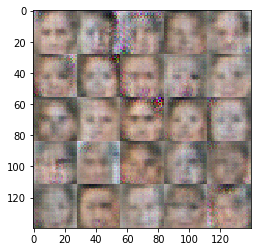

Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 0.8911... Generator Loss: 0.9849
Epoch 1/1... Discriminator Loss: 1.5846... Generator Loss: 0.6271
Epoch 1/1... Discriminator Loss: 0.1490... Generator Loss: 3.6491
Epoch 1/1... Discriminator Loss: 0.6286... Generator Loss: 3.4187
Epoch 1/1... Discriminator Loss: 1.2098... Generator Loss: 0.8831
Epoch 1/1... Discriminator Loss: 0.5431... Generator Loss: 1.3704
Epoch 1/1... Discriminator Loss: 1.9923... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 0.8107... Generator Loss: 0.8523
Epoch 1/1... Discriminator Loss: 0.0840... Generator Loss: 3.5459


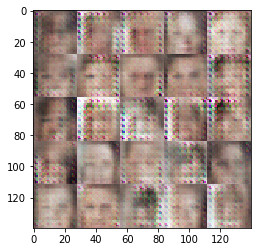

Epoch 1/1... Discriminator Loss: 0.9585... Generator Loss: 1.0887
Epoch 1/1... Discriminator Loss: 1.7615... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 0.4319... Generator Loss: 1.9905
Epoch 1/1... Discriminator Loss: 0.0731... Generator Loss: 4.8253
Epoch 1/1... Discriminator Loss: 0.1911... Generator Loss: 1.9576
Epoch 1/1... Discriminator Loss: 1.5996... Generator Loss: 0.8261
Epoch 1/1... Discriminator Loss: 1.0785... Generator Loss: 0.9478
Epoch 1/1... Discriminator Loss: 1.3131... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.9658
Epoch 1/1... Discriminator Loss: 1.5592... Generator Loss: 0.5754


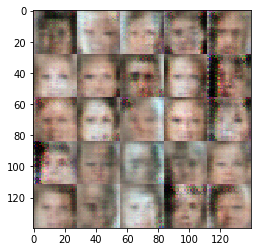

Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.8386
Epoch 1/1... Discriminator Loss: 1.5612... Generator Loss: 0.5902
Epoch 1/1... Discriminator Loss: 0.9805... Generator Loss: 1.2061
Epoch 1/1... Discriminator Loss: 0.4518... Generator Loss: 1.2684
Epoch 1/1... Discriminator Loss: 0.0226... Generator Loss: 4.9923
Epoch 1/1... Discriminator Loss: 0.0157... Generator Loss: 5.9695
Epoch 1/1... Discriminator Loss: 0.0240... Generator Loss: 4.0031
Epoch 1/1... Discriminator Loss: 0.1028... Generator Loss: 2.6456
Epoch 1/1... Discriminator Loss: 0.0180... Generator Loss: 4.7245
Epoch 1/1... Discriminator Loss: 1.1923... Generator Loss: 1.1707


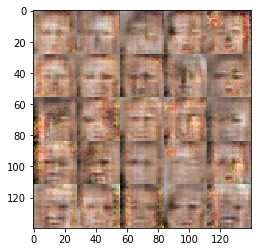

Epoch 1/1... Discriminator Loss: 1.4907... Generator Loss: 0.9275
Epoch 1/1... Discriminator Loss: 1.7238... Generator Loss: 0.9214
Epoch 1/1... Discriminator Loss: 1.1950... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 1.6441... Generator Loss: 1.3952
Epoch 1/1... Discriminator Loss: 1.5629... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.4832
Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 1.4391
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.8354
Epoch 1/1... Discriminator Loss: 1.6710... Generator Loss: 1.5761


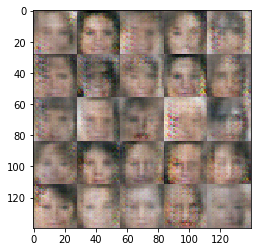

Epoch 1/1... Discriminator Loss: 1.6913... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 2.6813... Generator Loss: 0.1241
Epoch 1/1... Discriminator Loss: 1.1640... Generator Loss: 0.5999
Epoch 1/1... Discriminator Loss: 5.1410... Generator Loss: 4.5668
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.6401
Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 1.4526
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.6448
Epoch 1/1... Discriminator Loss: 1.7335... Generator Loss: 0.6473
Epoch 1/1... Discriminator Loss: 2.0286... Generator Loss: 2.1401
Epoch 1/1... Discriminator Loss: 0.3575... Generator Loss: 2.1584


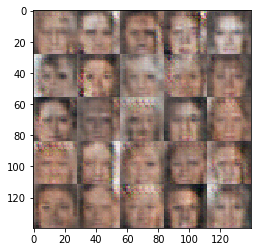

Epoch 1/1... Discriminator Loss: 0.4472... Generator Loss: 1.4074
Epoch 1/1... Discriminator Loss: 1.7768... Generator Loss: 0.9126
Epoch 1/1... Discriminator Loss: 0.4973... Generator Loss: 1.3878
Epoch 1/1... Discriminator Loss: 0.6964... Generator Loss: 1.1965
Epoch 1/1... Discriminator Loss: 0.1653... Generator Loss: 2.0392
Epoch 1/1... Discriminator Loss: 0.0334... Generator Loss: 4.1620
Epoch 1/1... Discriminator Loss: 0.9471... Generator Loss: 0.9712
Epoch 1/1... Discriminator Loss: 0.5736... Generator Loss: 1.1631
Epoch 1/1... Discriminator Loss: 0.1356... Generator Loss: 5.4648
Epoch 1/1... Discriminator Loss: 3.4504... Generator Loss: 5.5314


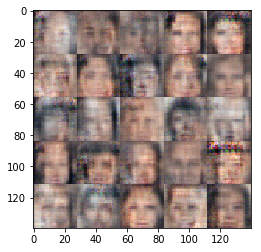

Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 1.5504
Epoch 1/1... Discriminator Loss: 1.5847... Generator Loss: 0.8128
Epoch 1/1... Discriminator Loss: 0.6996... Generator Loss: 1.5350
Epoch 1/1... Discriminator Loss: 0.0692... Generator Loss: 3.1485
Epoch 1/1... Discriminator Loss: 0.1507... Generator Loss: 7.4848
Epoch 1/1... Discriminator Loss: 0.0343... Generator Loss: 3.6111
Epoch 1/1... Discriminator Loss: 0.0644... Generator Loss: 3.0020
Epoch 1/1... Discriminator Loss: 0.0296... Generator Loss: 4.6235
Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 4.6643
Epoch 1/1... Discriminator Loss: 1.5516... Generator Loss: 0.7288


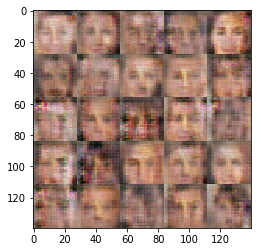

Epoch 1/1... Discriminator Loss: 2.0938... Generator Loss: 0.2159
Epoch 1/1... Discriminator Loss: 0.9762... Generator Loss: 0.9508
Epoch 1/1... Discriminator Loss: 1.0527... Generator Loss: 0.9984
Epoch 1/1... Discriminator Loss: 2.1806... Generator Loss: 2.0608
Epoch 1/1... Discriminator Loss: 0.9433... Generator Loss: 1.0485
Epoch 1/1... Discriminator Loss: 1.1241... Generator Loss: 1.2146
Epoch 1/1... Discriminator Loss: 1.2680... Generator Loss: 1.4135
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.4966
Epoch 1/1... Discriminator Loss: 1.5765... Generator Loss: 1.0158
Epoch 1/1... Discriminator Loss: 1.5575... Generator Loss: 0.4648


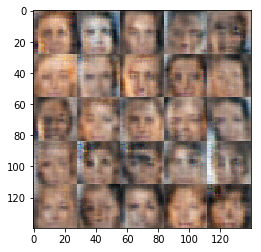

Epoch 1/1... Discriminator Loss: 1.5324... Generator Loss: 0.8886
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 1.0349
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 1.0388... Generator Loss: 1.0251
Epoch 1/1... Discriminator Loss: 1.1840... Generator Loss: 0.8497
Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 1.2007
Epoch 1/1... Discriminator Loss: 1.1273... Generator Loss: 0.8803
Epoch 1/1... Discriminator Loss: 1.2577... Generator Loss: 1.1935


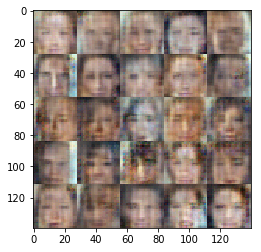

Epoch 1/1... Discriminator Loss: 1.0751... Generator Loss: 0.9998
Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.1294... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 1.0310... Generator Loss: 0.8999
Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 0.6630
Epoch 1/1... Discriminator Loss: 0.9598... Generator Loss: 1.0579
Epoch 1/1... Discriminator Loss: 1.4992... Generator Loss: 1.7583
Epoch 1/1... Discriminator Loss: 1.1017... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 1.1798... Generator Loss: 0.8712
Epoch 1/1... Discriminator Loss: 1.2046... Generator Loss: 0.8856


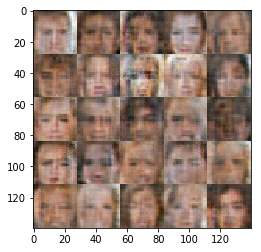

Epoch 1/1... Discriminator Loss: 1.2853... Generator Loss: 2.0601
Epoch 1/1... Discriminator Loss: 0.9445... Generator Loss: 0.9594
Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 0.4747
Epoch 1/1... Discriminator Loss: 1.5196... Generator Loss: 0.3455
Epoch 1/1... Discriminator Loss: 1.0495... Generator Loss: 0.8735
Epoch 1/1... Discriminator Loss: 1.2568... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.0718... Generator Loss: 1.4572
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 0.5002
Epoch 1/1... Discriminator Loss: 1.1015... Generator Loss: 2.2863
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.6520


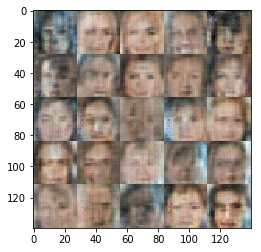

Epoch 1/1... Discriminator Loss: 1.1475... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 1.6830... Generator Loss: 0.3925
Epoch 1/1... Discriminator Loss: 1.7648... Generator Loss: 0.3390
Epoch 1/1... Discriminator Loss: 1.0121... Generator Loss: 0.7518
Epoch 1/1... Discriminator Loss: 0.9060... Generator Loss: 1.0922
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 1.2679
Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.4387
Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 1.1881
Epoch 1/1... Discriminator Loss: 1.0801... Generator Loss: 0.8617


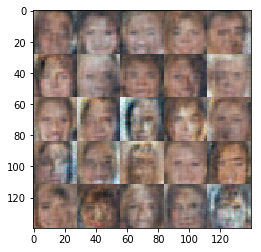

Epoch 1/1... Discriminator Loss: 1.6745... Generator Loss: 1.4617
Epoch 1/1... Discriminator Loss: 1.0882... Generator Loss: 1.0461
Epoch 1/1... Discriminator Loss: 0.8568... Generator Loss: 1.2685
Epoch 1/1... Discriminator Loss: 0.4273... Generator Loss: 2.1905
Epoch 1/1... Discriminator Loss: 0.9169... Generator Loss: 1.1044
Epoch 1/1... Discriminator Loss: 0.9498... Generator Loss: 0.9730
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.4931
Epoch 1/1... Discriminator Loss: 0.7953... Generator Loss: 1.3272
Epoch 1/1... Discriminator Loss: 2.3545... Generator Loss: 2.8132
Epoch 1/1... Discriminator Loss: 0.9024... Generator Loss: 0.9394


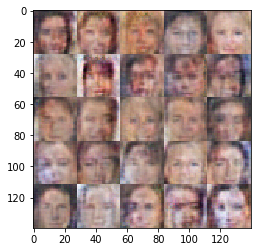

Epoch 1/1... Discriminator Loss: 1.4498... Generator Loss: 0.4187
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.5228
Epoch 1/1... Discriminator Loss: 0.6264... Generator Loss: 1.1900
Epoch 1/1... Discriminator Loss: 1.0479... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.0873... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.0196... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 2.0144... Generator Loss: 0.1966
Epoch 1/1... Discriminator Loss: 0.7741... Generator Loss: 1.2669
Epoch 1/1... Discriminator Loss: 1.2881... Generator Loss: 0.4201
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.4796


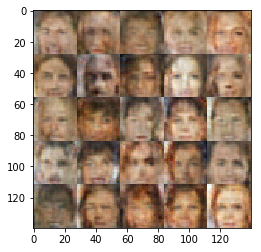

Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.9599
Epoch 1/1... Discriminator Loss: 1.1614... Generator Loss: 0.6080
Epoch 1/1... Discriminator Loss: 1.0554... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 2.7008... Generator Loss: 0.1257
Epoch 1/1... Discriminator Loss: 1.1180... Generator Loss: 0.5921
Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 0.4691
Epoch 1/1... Discriminator Loss: 0.9333... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 0.7397... Generator Loss: 1.1607
Epoch 1/1... Discriminator Loss: 0.8685... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 2.4558... Generator Loss: 0.1532


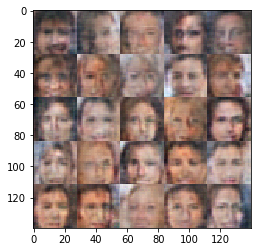

Epoch 1/1... Discriminator Loss: 0.4989... Generator Loss: 3.8470
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 1.1271... Generator Loss: 0.5910
Epoch 1/1... Discriminator Loss: 0.9669... Generator Loss: 2.2513
Epoch 1/1... Discriminator Loss: 0.6459... Generator Loss: 1.2850
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 0.4722
Epoch 1/1... Discriminator Loss: 1.0288... Generator Loss: 0.9444
Epoch 1/1... Discriminator Loss: 2.4712... Generator Loss: 0.1368
Epoch 1/1... Discriminator Loss: 0.5955... Generator Loss: 2.0077
Epoch 1/1... Discriminator Loss: 2.2590... Generator Loss: 2.8618


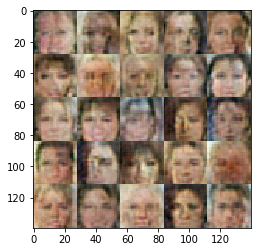

Epoch 1/1... Discriminator Loss: 0.8944... Generator Loss: 1.6858
Epoch 1/1... Discriminator Loss: 0.8849... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 0.9981... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 0.4840... Generator Loss: 1.6204
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 0.5317
Epoch 1/1... Discriminator Loss: 0.9986... Generator Loss: 2.0300
Epoch 1/1... Discriminator Loss: 0.4947... Generator Loss: 2.0175
Epoch 1/1... Discriminator Loss: 0.4731... Generator Loss: 2.1222
Epoch 1/1... Discriminator Loss: 0.8181... Generator Loss: 1.0867
Epoch 1/1... Discriminator Loss: 1.0526... Generator Loss: 0.7933


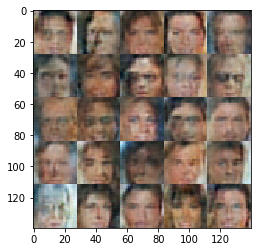

Epoch 1/1... Discriminator Loss: 0.5633... Generator Loss: 1.3389
Epoch 1/1... Discriminator Loss: 0.7122... Generator Loss: 0.9268
Epoch 1/1... Discriminator Loss: 1.7297... Generator Loss: 0.2851
Epoch 1/1... Discriminator Loss: 0.6843... Generator Loss: 1.2581
Epoch 1/1... Discriminator Loss: 1.9738... Generator Loss: 0.2453
Epoch 1/1... Discriminator Loss: 1.5472... Generator Loss: 0.3583
Epoch 1/1... Discriminator Loss: 1.9379... Generator Loss: 0.3016
Epoch 1/1... Discriminator Loss: 0.6940... Generator Loss: 1.2189
Epoch 1/1... Discriminator Loss: 0.9498... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 0.6357... Generator Loss: 2.3333


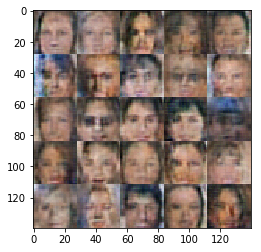

Epoch 1/1... Discriminator Loss: 0.8909... Generator Loss: 1.0194
Epoch 1/1... Discriminator Loss: 0.7528... Generator Loss: 1.2498
Epoch 1/1... Discriminator Loss: 0.4997... Generator Loss: 2.6495
Epoch 1/1... Discriminator Loss: 2.4427... Generator Loss: 0.1544
Epoch 1/1... Discriminator Loss: 0.5018... Generator Loss: 2.0487
Epoch 1/1... Discriminator Loss: 2.1610... Generator Loss: 0.1934
Epoch 1/1... Discriminator Loss: 0.8389... Generator Loss: 2.5183
Epoch 1/1... Discriminator Loss: 1.8937... Generator Loss: 0.2440
Epoch 1/1... Discriminator Loss: 0.8062... Generator Loss: 2.3540
Epoch 1/1... Discriminator Loss: 0.4694... Generator Loss: 1.9852


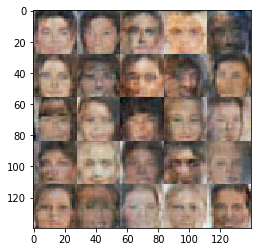

Epoch 1/1... Discriminator Loss: 0.7178... Generator Loss: 1.2784
Epoch 1/1... Discriminator Loss: 1.0757... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 0.3550... Generator Loss: 1.4709
Epoch 1/1... Discriminator Loss: 0.8128... Generator Loss: 3.7321
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.5653
Epoch 1/1... Discriminator Loss: 0.9018... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.5160... Generator Loss: 0.3852
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.4836
Epoch 1/1... Discriminator Loss: 2.2236... Generator Loss: 0.2096
Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.3834


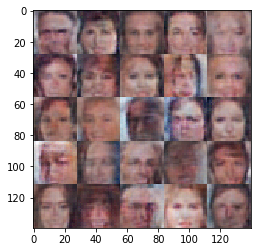

Epoch 1/1... Discriminator Loss: 0.4296... Generator Loss: 1.5411
Epoch 1/1... Discriminator Loss: 1.2756... Generator Loss: 0.5612
Epoch 1/1... Discriminator Loss: 1.1297... Generator Loss: 0.6042
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.4369
Epoch 1/1... Discriminator Loss: 1.6953... Generator Loss: 3.5960
Epoch 1/1... Discriminator Loss: 1.8321... Generator Loss: 0.3049
Epoch 1/1... Discriminator Loss: 0.7874... Generator Loss: 0.9302
Epoch 1/1... Discriminator Loss: 0.7345... Generator Loss: 1.5562
Epoch 1/1... Discriminator Loss: 0.6893... Generator Loss: 1.1216
Epoch 1/1... Discriminator Loss: 0.9635... Generator Loss: 0.6668


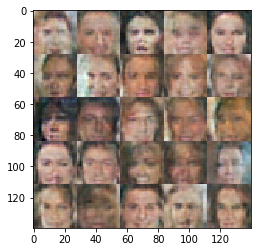

Epoch 1/1... Discriminator Loss: 0.7795... Generator Loss: 0.8462
Epoch 1/1... Discriminator Loss: 1.2162... Generator Loss: 0.6073
Epoch 1/1... Discriminator Loss: 0.9291... Generator Loss: 0.9577
Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 2.8566
Epoch 1/1... Discriminator Loss: 1.0125... Generator Loss: 0.6522
Epoch 1/1... Discriminator Loss: 2.1963... Generator Loss: 0.1814
Epoch 1/1... Discriminator Loss: 0.8541... Generator Loss: 1.0796
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.4553
Epoch 1/1... Discriminator Loss: 1.5047... Generator Loss: 0.3438
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.4331


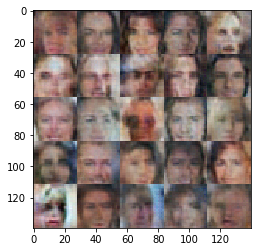

Epoch 1/1... Discriminator Loss: 1.2748... Generator Loss: 0.4498
Epoch 1/1... Discriminator Loss: 0.7672... Generator Loss: 1.0904
Epoch 1/1... Discriminator Loss: 1.0809... Generator Loss: 0.6605
Epoch 1/1... Discriminator Loss: 1.1213... Generator Loss: 1.8390
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 1.1508
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.4976
Epoch 1/1... Discriminator Loss: 1.9311... Generator Loss: 1.4271
Epoch 1/1... Discriminator Loss: 2.0406... Generator Loss: 0.2251
Epoch 1/1... Discriminator Loss: 0.5784... Generator Loss: 1.2266
Epoch 1/1... Discriminator Loss: 0.3802... Generator Loss: 2.7254


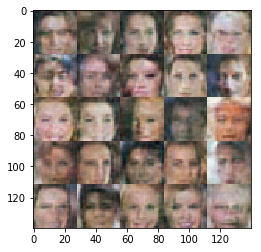

Epoch 1/1... Discriminator Loss: 1.8750... Generator Loss: 0.2633
Epoch 1/1... Discriminator Loss: 1.6821... Generator Loss: 0.3392
Epoch 1/1... Discriminator Loss: 0.3663... Generator Loss: 2.2052
Epoch 1/1... Discriminator Loss: 0.4618... Generator Loss: 1.3943
Epoch 1/1... Discriminator Loss: 0.6126... Generator Loss: 1.5557
Epoch 1/1... Discriminator Loss: 0.6856... Generator Loss: 1.0517


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.